# AR和PSY情绪类技术因子均线得分策略 - 第四组 - 陈孜越

策略概述：
1.	构造了AR和PSY情绪类技术指标，再将两个指标的均线组得分加总，总得分若超过一定阈值则生成金叉信号，若低于一定阈值则生成死叉信号。
2.	趋势识别，利用收盘价均线金叉死叉进行上涨和下跌趋势的识别，上涨标记为1，下跌标记为-1
3.  每小时进行调仓判断。若品种处于上涨趋势且金叉信号出现则做多，若品种处于下跌趋势且死叉信号出现则做空，其他情形则说明趋势不够明朗，因此进行平多或平空。
4.	每分钟进行止盈止损的判断 

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import pandas as pd
import numpy as np

########################################################################
# 策略继承CtaTemplate
class ARPSYMaStrategy(CtaTemplate):
   
    className = 'ARPSYMaStrategy'
    author = 'Chenziyue'
    
    # 策略参数
    fastPeriod = 6   # 判断趋势用到的短期均线时间长度 
    slowPeriod = 60   # 判断趋势用到的长期均线时间长度
    arPeriod = 15     # AR指标的时间参数
    psyPeriod = 12     # PSY指标的时间参数
    timePeriod = 18   # 均线组的个数
    multiplier = 4    # 长短期乘数
    upperthreshold = 0.65   # 买进的分数门槛
    lowerthreshold = 0.4   # 卖出的分数门槛
    stopRatio = 0.03    # 止损率
    lot = 1             # 设置手数
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod',
                 'arPeriod',
                 'psyPeriod',
                 'timePeriod',
                 'multiplier',
                 'upperthreshold',
                 'lowerthreshold',
                 'stopRatio',
                 'lot']    
    
    # 变量列表
    varList = ['maTrend',
               'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.maTrend = {s:0 for s in self.symbolList} 
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+5*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-5*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                #print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                #print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                #print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                #print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势-------------------------------------------------
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.maTrend[symbol] = -1        
       
        
        # 计算策略需要的信号-------------------------------------------------
        def calculate(factor,t):
            mas = ta.MA(factor, t)
            mal = ta.MA(factor, self.multiplier*t)
            df = np.vstack((mas,mal))
            scoretable = np.array(list(map(lambda s, l: 1 if s>l else 0, df[0,:], df[1,:])))
            return scoretable
        
        ar = ta.SUM(am60.high[1:]-am60.open[1:],self.arPeriod)/ta.SUM(am60.open[1:]-am60.low[1:],self.arPeriod)
        x = range(1,self.timePeriod+1,1)
        arscore = np.array([calculate(ar,t) for t in x]).transpose().sum(axis=1)
            
        psy = ta.SUM(np.array(am60.close[1:]>am60.close[:-1],dtype='double'),self.psyPeriod)/self.psyPeriod
        psyscore = np.array([calculate(psy,t) for t in x]).transpose().sum(axis=1)
        
        score = arscore+psyscore
     
        crossOver = (score[-1]>2*self.timePeriod*self.upperthreshold) and (score[-2]<2*self.timePeriod*self.upperthreshold)
        crossBelow = (score[-1]<2*self.timePeriod*self.lowerthreshold) and (score[-2]>2*self.timePeriod*self.lowerthreshold)
        
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果趋势向上且金叉出现
        if (self.maTrend[symbol]==1) and (crossOver):
            # 如果没有空头持仓，且持多仓位小于5，则直接做多
            if (self.posDict[symbol+'_SHORT']==0) and (self.posDict[symbol+'_LONG']<5):
                self.cancelAll()
                self.buy(symbol, bar.close*1.05, self.lot)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.05, self.lot)
        # 如果（趋势向上且死叉出现） 或者 （趋势向下且金叉出现）
        elif ((self.maTrend[symbol]==1) and (crossBelow)) or ((crossOver) and (self.maTrend[symbol]==-1)):
            # 有多平多，有空平空
            if self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT'])
        # 如果死叉出现，趋势向下
        elif (crossBelow) and (self.maTrend[symbol]==-1):
            # 如果没有多头持仓，则直接做空
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']<5):
                self.cancelAll()
                self.short(symbol, bar.close*0.95, self.lot)
            # 如果有多头持仓，则先平多，再做空
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG']) 
                self.short(symbol, bar.close*0.95, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
# 对BTCUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180101 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ARPSYMaStrategy.on60MinBar at 0x00000153DF30CC80>, <__main__.ARPSYMaStrategy object at 0x00000153CB160E48>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ARPSYMaStrategy.onBar at 0x00000153DF30CBF8>, <__main__.ARPSYMaStrategy object at 0x00000153CB160E48>)
2018-12-16 15:09:43.894400	开始回测
2018-12-16 15:09:43.894400	策略初始化
2018-12-16 15:09:43.894492	载入历史数据。数据范围:[20171229 22:00,20180101 00:00)
2018-12-16 15:09:44.035813	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:09:44.035897	载入完成，数据量：3000
2018-12-16 15:09:44.036809	策略初始化完成
2018-12-16 15:09:44.036809	策略启动完成
2018-12-16 15:09:44.036809	开始回放回测数据,回测范围:[20180101 00:00,20181201 00:00)
2018-12-16 15:09:44.071751	载入历史数据。数据范围:[20180101 00:00,20181201 00:00)
2018-12-16 15:09:56.688962	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:09:56.789692	载入完成，数据量：476984
2018-12-16 15:09:56

Traceback (most recent call last):
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811225-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\pandas\core\generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20171227200000 , 20171231230000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180101000100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180101000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 13226.16, 'high': 14030.0, 'low': 13192.02, 'close': 13836.0, 'date': '20180101', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 1, 1, 0, 0), 'volume': 1148.2082180000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20171227210000 , 20180101000000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180101000000
2018-12-16 15:10:24.688063	数据回放结束ss: 100%    


In [3]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-01-03 03:00:00,多,,,0.0,,开仓,1,,14576.87,0.0,None,,,1,2018-01-03 03:00:00,1,1,BTCUSDT:binance,1
2018-01-04 01:00:00,空,,,0.0,,平仓,2,,15011.00,0.0,None,,,2,2018-01-04 01:00:00,1,2,BTCUSDT:binance,2
2018-01-05 10:00:00,多,,,0.0,,开仓,3,,15038.04,0.0,None,,,3,2018-01-05 10:00:00,1,3,BTCUSDT:binance,3
2018-01-05 18:00:00,多,,,0.0,,开仓,4,,15873.50,0.0,None,,,4,2018-01-05 18:00:00,1,4,BTCUSDT:binance,4
2018-01-06 01:00:00,多,,,0.0,,开仓,5,,16449.00,0.0,None,,,5,2018-01-06 01:00:00,1,5,BTCUSDT:binance,5
2018-01-06 19:00:00,空,,,0.0,,平仓,6,,16690.20,0.0,None,,,6,2018-01-06 19:00:00,3,6,BTCUSDT:binance,6
2018-01-08 17:00:00,空,,,0.0,,开仓,7,,15471.00,0.0,None,,,7,2018-01-08 17:00:00,1,7,BTCUSDT:binance,7
2018-01-08 23:07:00,多,,,0.0,,平仓,8,,12910.00,0.0,None,,,8,2018-01-08 23:07:00,1,8,BTCUSDT:binance,8
2018-01-09 20:00:00,空,,,0.0,,开仓,9,,14726.00,0.0,None,,,9,2018-01-09 20:00:00,1,9,BTCUSDT:binance,9


2018-12-16 15:10:24.752598	计算按日统计结果
2018-12-16 15:10:24.782841	------------------------------
2018-12-16 15:10:24.782841	首个交易日：	2018-01-01 00:00:00
2018-12-16 15:10:24.782841	最后交易日：	2018-11-30 00:00:00
2018-12-16 15:10:24.782841	总交易日：	334
2018-12-16 15:10:24.782841	盈利交易日	124
2018-12-16 15:10:24.782841	亏损交易日：	122
2018-12-16 15:10:24.782841	起始资金：	1000000
2018-12-16 15:10:24.782841	结束资金：	1,021,853.98
2018-12-16 15:10:24.782841	总收益率：	2.19%
2018-12-16 15:10:24.782841	年化收益：	1.57%
2018-12-16 15:10:24.782841	总盈亏：	21,853.98
2018-12-16 15:10:24.782841	最大回撤: 	-3,559.25
2018-12-16 15:10:24.782841	百分比最大回撤: -0.35%
2018-12-16 15:10:24.782841	总手续费：	1,708.91
2018-12-16 15:10:24.782841	总滑点：	0.85
2018-12-16 15:10:24.782841	总成交金额：	3,417,824.48
2018-12-16 15:10:24.782841	总成交笔数：	365
2018-12-16 15:10:24.782841	日均盈亏：	65.43
2018-12-16 15:10:24.782841	日均手续费：	5.12
2018-12-16 15:10:24.782841	日均滑点：	0.0
2018-12-16 15:10:24.782841	日均成交金额：	10,233.01
2018-12-16 15:10:24.782841	日均成交笔数：	1.09
2018-12-16 15:10:24.782841	日

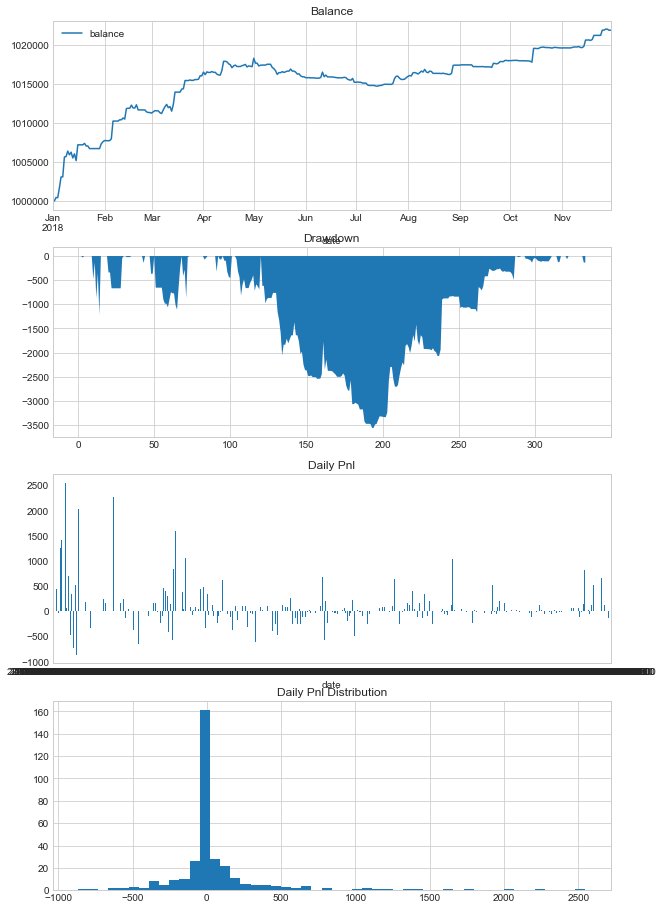

In [4]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 15:10:28.023139	计算回测结果
2018-12-16 15:10:28.341320	------------------------------
2018-12-16 15:10:28.342359	第一笔交易：	2018-01-04 01:00:00
2018-12-16 15:10:28.342359	最后一笔交易：	2018-11-29 12:06:00
2018-12-16 15:10:28.342359	总交易次数：	213
2018-12-16 15:10:28.342359	总盈亏：	21,853.98
2018-12-16 15:10:28.342359	最大回撤: 	-3,171.99
2018-12-16 15:10:28.342359	平均每笔盈利：	102.6
2018-12-16 15:10:28.342359	平均每笔滑点：	0.0
2018-12-16 15:10:28.342359	平均每笔佣金：	8.02
2018-12-16 15:10:28.342359	胜率		47.89%
2018-12-16 15:10:28.342359	盈利交易平均值	357.21
2018-12-16 15:10:28.342359	亏损交易平均值	-131.36
2018-12-16 15:10:28.342359	盈亏比：	2.72


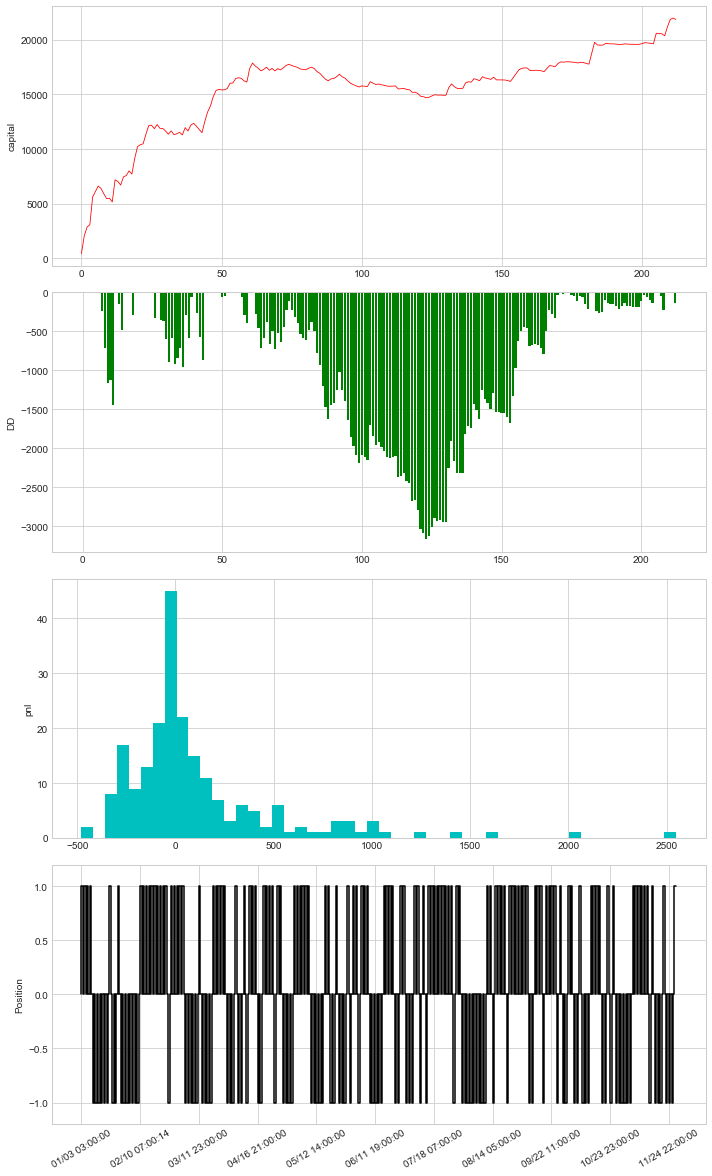

In [5]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
# 对EOSUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function ARPSYMaStrategy.on60MinBar at 0x00000153FCA67730>, <__main__.ARPSYMaStrategy object at 0x00000153FCCCE160>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function ARPSYMaStrategy.onBar at 0x00000153FD46D400>, <__main__.ARPSYMaStrategy object at 0x00000153FCCCE160>)
2018-12-16 15:10:29.236053	开始回测
2018-12-16 15:10:29.236053	策略初始化
2018-12-16 15:10:29.236053	载入历史数据。数据范围:[20180628 22:00,20180701 00:00)
2018-12-16 15:10:29.351587	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:10:29.351587	载入完成，数据量：3000
2018-12-16 15:10:29.352584	策略初始化完成
2018-12-16 15:10:29.352584	策略启动完成
2018-12-16 15:10:29.352584	开始回放回测数据,回测范围:[20180701 00:00,20181201 00:00)
2018-12-16 15:10:29.366584	载入历史数据。数据范围:[20180701 00:00,20181201 00:00)
2018-12-16 15:10:35.375693	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 15:10:35.421439	载入完成，数据量：219233
2018-12-16 15:10:35

Traceback (most recent call last):
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811225-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\chenziyue\Anaconda3\lib\site-packages\pandas\core\generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626090000 , 20180630230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 8.0545, 'high': 8.0734, 'low': 7.9332000000000003, 'close': 7.9964000000000004, 'date': '20180701', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 0, 0), 'volume': 347359.58999999991, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626200000 , 20180701000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180701000000
2018-12-16 15:10:51.682112	数据回放结束ss: 100%    


2018-12-16 15:10:51.687063	计算按日统计结果
2018-12-16 15:10:51.708006	------------------------------
2018-12-16 15:10:51.708006	首个交易日：	2018-07-01 00:00:00
2018-12-16 15:10:51.708006	最后交易日：	2018-11-30 00:00:00
2018-12-16 15:10:51.708006	总交易日：	153
2018-12-16 15:10:51.708006	盈利交易日	42
2018-12-16 15:10:51.708006	亏损交易日：	62
2018-12-16 15:10:51.708006	起始资金：	1000000
2018-12-16 15:10:51.708006	结束资金：	1,000,005.72
2018-12-16 15:10:51.708472	总收益率：	0.0%
2018-12-16 15:10:51.708552	年化收益：	0.0%
2018-12-16 15:10:51.708584	总盈亏：	5.72
2018-12-16 15:10:51.708584	最大回撤: 	-1.74
2018-12-16 15:10:51.708690	百分比最大回撤: -0.0%
2018-12-16 15:10:51.708720	总手续费：	0.58
2018-12-16 15:10:51.708720	总滑点：	0.39
2018-12-16 15:10:51.708805	总成交金额：	1,160.34
2018-12-16 15:10:51.708825	总成交笔数：	165
2018-12-16 15:10:51.708825	日均盈亏：	0.04
2018-12-16 15:10:51.708877	日均手续费：	0.0
2018-12-16 15:10:51.708921	日均滑点：	0.0
2018-12-16 15:10:51.708921	日均成交金额：	7.58
2018-12-16 15:10:51.708921	日均成交笔数：	1.08
2018-12-16 15:10:51.708921	日均收益率：	0.0%
2018-12-16 15:10:5

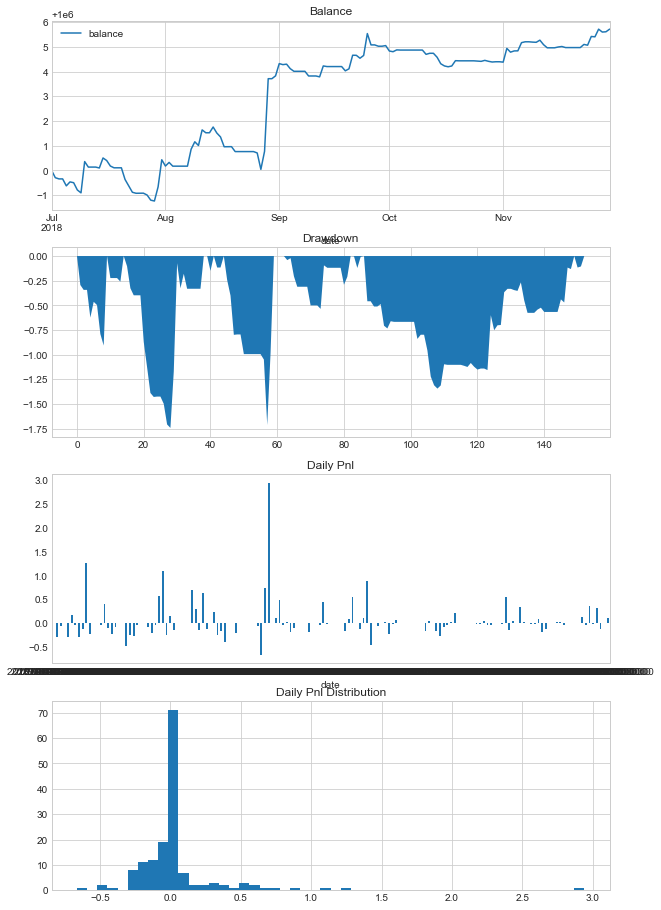

In [7]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-16 15:10:53.352643	计算回测结果
2018-12-16 15:10:53.359619	------------------------------
2018-12-16 15:10:53.359619	第一笔交易：	2018-07-02 21:28:00
2018-12-16 15:10:53.360009	最后一笔交易：	2018-11-30 23:58:00
2018-12-16 15:10:53.360009	总交易次数：	97
2018-12-16 15:10:53.360009	总盈亏：	5.71
2018-12-16 15:10:53.360009	最大回撤: 	-1.64
2018-12-16 15:10:53.360009	平均每笔盈利：	0.06
2018-12-16 15:10:53.360009	平均每笔滑点：	0.0
2018-12-16 15:10:53.360009	平均每笔佣金：	0.01
2018-12-16 15:10:53.360388	胜率		41.24%
2018-12-16 15:10:53.360450	盈利交易平均值	0.33
2018-12-16 15:10:53.360485	亏损交易平均值	-0.13
2018-12-16 15:10:53.360517	盈亏比：	2.5


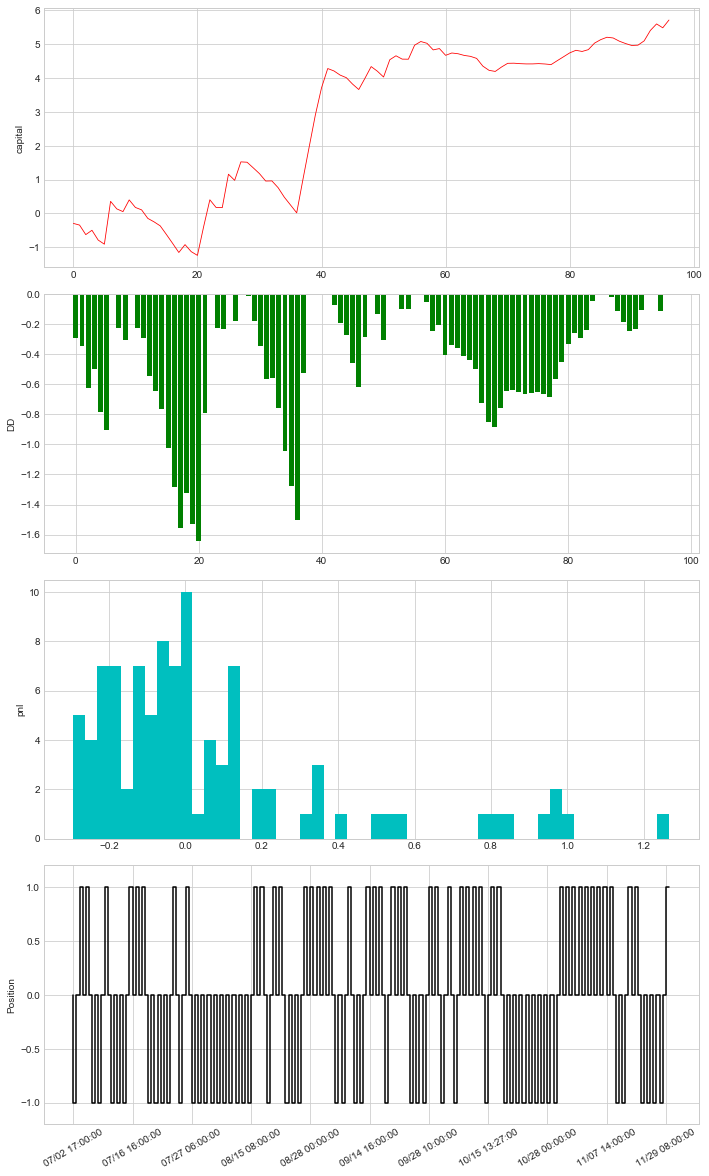

In [8]:
# 显示逐笔回测结果
engine.showBacktestingResult()